In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange
from IPython.display import Video


from nmf_grooming import (
    NeuromechflyGrooming,
    all_groom_dofs, 
    plot_state_and_contacts,
    load_grooming_data,
)

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import tethered



0 joint_Head
1 joint_Head_yaw
2 joint_Head_roll
3 joint_LHCoxa
4 joint_LHCoxa_roll
5 joint_LHCoxa_yaw
6 joint_LHFemur
7 joint_LHFemur_roll
8 joint_LHTibia
9 joint_LHTarsus1
10 joint_RHCoxa
11 joint_RHCoxa_roll
12 joint_RHCoxa_yaw
13 joint_RHFemur
14 joint_RHFemur_roll
15 joint_RHTibia
16 joint_RHTarsus1
17 joint_LPedicel
18 joint_LPedicel_yaw
19 joint_RPedicel
20 joint_RPedicel_yaw
21 joint_A1A2
22 joint_A3
23 joint_A4
24 joint_A5
25 joint_A6
26
3 10


In [2]:
LH_COXA = 3
LH_COXA_YAW = 4
LH_COXA_ROLL = 5
LH_FEMUR = 6
LH_FEMUR_ROLL = 7
LH_TIBIA = 8
LH_TARSUS = 9

RH_COXA = 10
RH_COXA_YAW = 11
RH_COXA_ROLL = 12
RH_FEMUR = 13
RH_FEMUR_ROLL = 14
RH_TIBIA = 15
RH_TARSUS = 16

L_PEDICEL = 17
L_PEDICEL_YAW = 18

R_PEDICEL = 19
R_PEDICEL_YAW = 20

A1A2 = 21
A3 = 22
A4 = 23
A5 = 24
A6 = 25

##### Load the grooming data

In [3]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [4]:
print("foreleg",grooming_modules['foreleg'][:,1])
print('len',len(grooming_modules['foreleg']), len(grooming_modules['foreleg'][0]))
print('len',len(grooming_modules['eyes']), len(grooming_modules['eyes'][0]))
#print(type(grooming_modules['timestep']))
#print("timestep",grooming_modules['timestep'])
#plt.plot(grooming_modules['foreleg'])
#plt.show()
print(grooming_modules.keys())


foreleg [-0.08523588 -0.04243297  0.01901747  0.46856522  0.40910696 -0.54994702
 -2.21690638  0.38629387  1.34666447 -1.34909617  0.42275158 -0.47830593
  0.212536   -2.4500765  -0.87076495  1.8786287  -1.07097343 -0.42621139
  0.97420563 -0.42621139 -0.97420563]
len 21 558
len 21 819
dict_keys(['foreleg', 'R_antenna', 'L_antenna', 'eyes', 'timestep'])


#### Foreleg joint position (not symmetrical)

In [6]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_front",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)

target_joint_angles_front = grooming_modules["foreleg"][:, :target_num_steps]
abd_arr = 0.25*np.ones((5, 558))
target_joint_angles_front = np.concatenate([target_joint_angles_front, abd_arr], axis=0)
print(np.shape(target_joint_angles_front))

nbre_step = len(grooming_modules['foreleg'][0])-1
# 10 loops of frontleg grooming
replay_steps = [nbre_step,2*nbre_step,3*nbre_step,4*nbre_step,5*nbre_step,
                6*nbre_step,7*nbre_step,8*nbre_step,9*nbre_step,10*nbre_step]
joint_pos = np.zeros(26)
k = 0
nmf.reset()
for i in trange(10*558):
    joint_pos = target_joint_angles_front[:, k]
    
    action = {"joints": joint_pos}
    nmf.step(action)
    nmf.render()
    if i in replay_steps:
        k = 0
    else:
        k += 1
        
if sim_params.render_camera == "Animat/camera_front":
    frontleg_video = "frontleg_groom_front.mp4"
else:
    frontleg_video = "frontleg_groom_left.mp4"  

nmf.save_video(frontleg_video)

(26, 558)


100%|██████████| 5580/5580 [00:10<00:00, 544.25it/s]


In [ ]:
Video("frontleg_groom_left.mp4")

##### Update target_joint_angles_front de base pour resserrer les legs

In [ ]:
plt.plot(target_joint_angles_front[4,:])

In [ ]:
target_joint_angles_front = target_joint_angles_front.copy()
target_joint_angles_front[4,:] = target_joint_angles_front[4,:]+np.pi/3

#### Get symetrical movement

In [107]:
symetric_leg = np.zeros_like(target_joint_angles_front) # contains all the joint angles for front leg grooming symmetrically

for i in range(len(target_joint_angles_front)):
    if i in [10,13,15,16]:
        symetric_leg[i,:] = target_joint_angles_front[i-7,:] # map the right pitch leg to the left leg
    elif i in [11,12,14]:
        symetric_leg[i,:] = -target_joint_angles_front[i-7,:] # map the right yaw7roll leg to the left leg
    else:
        symetric_leg[i,:] = target_joint_angles_front[i,:]


##### Delay the right leg movement / joint position

In [48]:
def delay_sequence(seq, start_row, end_row, delay):
    # Extract rows to be delayed
    shifted_seq = seq.copy()
    rows_to_shift = seq[start_row:end_row+1,:]


    # Extract columns
    new_col = rows_to_shift[:, delay:]
    first_columns = rows_to_shift[:, :delay]

    shifted_columns = np.concatenate([new_col, first_columns], axis=1)
    shifted_seq[start_row:end_row+1,:] = shifted_columns
    return shifted_seq

In [108]:
initial_sequence = symetric_leg.copy()
rep = 5
delay = 279
repeated_sequence = np.tile(initial_sequence, (1, rep))

delayed_sequence = delay_sequence(repeated_sequence, 10, 16, delay)
print(delayed_sequence.shape)


(26, 2790)


#### Front leg grooming symmetrical

In [91]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_front",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)

# seq_foreleg = grooming_modules["foreleg"][:, :target_num_steps]
# abd_arr = 0.25*np.ones((5, 558))
# sequence = np.concatenate([seq_foreleg, abd_arr], axis=0)
# sequence = symetric_leg
# target_joint_angles_rep = np.tile(sequence, (1, rep))

joint_pos = np.zeros(26)

nmf.reset()
for i in trange(rep*558):
    joint_pos = delayed_sequence[:, i]
    action = {"joints": joint_pos}
    nmf.step(action)
    nmf.render()
        
if sim_params.render_camera == "Animat/camera_front":
    frontleg_video = "frontleg_sym_front.mp4"
elif sim_params.render_camera == "Animat/camera_left":
    frontleg_video = "frontleg_sym_left.mp4"
elif sim_params.render_camera == "Animat/camera_right":
    frontleg_video = "frontleg_sym_right.mp4"
else:
    frontleg_video = "frontleg_sym_back.mp4"  

nmf.save_video(frontleg_video)

100%|██████████| 2790/2790 [00:06<00:00, 460.48it/s]


In [92]:
Video(frontleg_video)

#### hind groom symmetrical

In [ ]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_back",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)

target_joint_angles_back = symetric_leg

nbre_step = len(grooming_modules['foreleg'][0])-1
# 10 loops of frontleg grooming
replay_steps = [nbre_step,2*nbre_step,3*nbre_step,4*nbre_step,5*nbre_step,
                6*nbre_step,7*nbre_step,8*nbre_step,9*nbre_step,10*nbre_step]
joint_pos = np.zeros(26)
k = 0
nmf.reset()
for i in trange(10*558):
    for j in range(26):
        if j == 3 or j == 10: # Coxa --> extend backwards
            joint_pos[j] = target_joint_angles_back[j, k] + np.pi/12
        elif j == 6 or j == 13: # Femur
            joint_pos[j] = target_joint_angles_back[j, k] + 7*np.pi/6
        elif j == 8 or j == 15: # Tibia 
            joint_pos[j] = target_joint_angles_back[j, k] - 6*np.pi/7
        # # elif j == 9 : # Left Tarsus
        # #     joint_pos[j] = target_joint_angles_back[j, k] + 2*np.pi/3
        elif j == 9 or j == 16: # Right Tarsus
            joint_pos[j] = target_joint_angles_back[j, k] + 2*np.pi/3
        # elif j == 4: # Coxa yaw
        #     joint_pos[j] = target_joint_angles_back[j, k] + np.pi/12
        # elif j == 11:
        #     joint_pos[j] = target_joint_angles_back[j, k] - np.pi/12
        else:
            joint_pos[j] = target_joint_angles_back[j, k]
    
    action = {"joints": joint_pos}
    nmf.step(action)
    nmf.render()

    if i in replay_steps:
        k = 0
    else:
        k += 1    
        
if sim_params.render_camera == "Animat/camera_front":
    frontleg_video = "hindleg_sym_front.mp4"

elif sim_params.render_camera == "Animat/camera_left":
    frontleg_video = "hindleg_sym_left.mp4"

else:
    frontleg_video = "hindleg_sym_back.mp4"  
    
nmf.save_video(frontleg_video)

#### Left leg becomes right leg et vice versa

In [93]:
inverse_leg_joint = delayed_sequence.copy()

inverse_leg_joint[3:10,:], inverse_leg_joint[10:17,:] = inverse_leg_joint[10:17,:].copy(), inverse_leg_joint[3:10,:].copy()

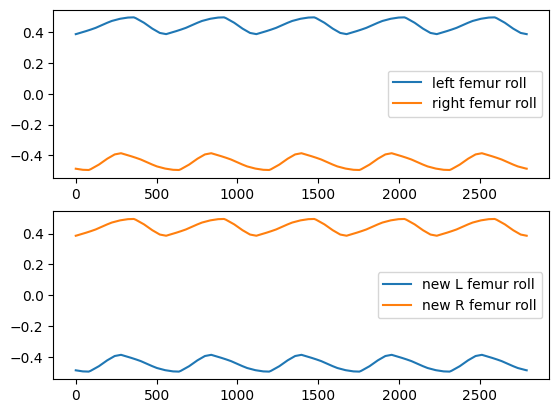

In [94]:
plt.subplot(2,1,1)
plt.plot(delayed_sequence[7,:], label='left femur roll')
plt.plot(delayed_sequence[14,:], label='right femur roll')
plt.legend()

plt.subplot(2,1,2)
plt.plot(inverse_leg_joint[7,:], label='new L femur roll')
plt.plot(inverse_leg_joint[14,:], label='new R femur roll')
plt.legend()

#### Try front leg groom sym and inverse leg (left and right)

In [ ]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_left",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)


nbre_step = len(grooming_modules['foreleg'][0])-1
# 10 loops of frontleg grooming
replay_steps = [nbre_step,2*nbre_step,3*nbre_step,4*nbre_step,5*nbre_step,
                6*nbre_step,7*nbre_step,8*nbre_step,9*nbre_step,10*nbre_step]
joint_pos = np.zeros(26)
k = 0
nmf.reset()
for i in trange(10*558):
    joint_pos = inverse_leg_joint[:, k]
    
    action = {"joints": joint_pos}
    nmf.step(action)
    nmf.render()
    if i in replay_steps:
        k = 0
    else:
        k += 1
        
if sim_params.render_camera == "Animat/camera_front":
    frontleg_video = "frontleg_sym_front_LR.mp4"
elif sim_params.render_camera == "Animat/camera_left":
    frontleg_video = "frontleg_sym_left_LR.mp4"
else:
    frontleg_video = "frontleg_sym_back_LR.mp4" 

nmf.save_video(frontleg_video)

#### Hind leg groom sym, inverse right and left leg

In [146]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_back",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)

target_joint_angles_back = delayed_sequence.copy()
joint_pos = np.zeros(26)

nmf.reset()
for i in trange(5*558):
    for j in range(26):
        if j == 3 or j == 10: # Coxa --> extend backwards
            joint_pos[j] = target_joint_angles_back[j, i] + np.pi/12
        # # elif j == 5:  # Coxa roll
        # #     joint_pos[j] = -target_joint_angles_back[j, i]
        elif j == 6 or j == 13: # Femur
            joint_pos[j] = target_joint_angles_back[j, i] + 7*np.pi/6
        elif j == 8 or j == 15: # Tibia 
            joint_pos[j] = target_joint_angles_back[j, i] - 6*np.pi/7
        # # # elif j == 9 : # Left Tarsus
        # # #     joint_pos[j] = target_joint_angles_back[j, k] + 2*np.pi/3
        elif j == 9 or j == 16: # Tarsus
            joint_pos[j] = target_joint_angles_back[j, i] + 2*np.pi/3
        # elif j == 4: # Coxa yaw
        #     joint_pos[j] = target_joint_angles_back[j, i] - np.pi/12
        # elif j == 11:
        #     joint_pos[j] = target_joint_angles_back[j, i] + np.pi/12
        elif j in [21,22,23,24,25]: # up abdomen to see better
            joint_pos[j] = target_joint_angles_back[j, i] + np.pi/2
        else:
            joint_pos[j] = target_joint_angles_back[j, i]
    
    action = {"joints": joint_pos}
    nmf.step(action)
    nmf.render()
        
if sim_params.render_camera == "Animat/camera_front":
    frontleg_video = "hindleg_sym_front_LR.mp4"

elif sim_params.render_camera == "Animat/camera_left":
    frontleg_video = "hindleg_sym_left_LR.mp4"

else:
    frontleg_video = "hindleg_sym_back_LR.mp4"  
    
nmf.save_video(frontleg_video)

100%|██████████| 2790/2790 [00:09<00:00, 279.84it/s]


In [130]:
Video(frontleg_video)

Plots angles of foreleg joints (at the hindleg place, but who cares)

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(target_joint_angles[3,:], label='Pitch', color='red')
plt.plot(target_joint_angles[4,:], label='Yaw', color='green')
plt.plot(target_joint_angles[5,:], label='Roll', color='blue')
plt.title('Left Coxa orientation')
plt.xlabel('timestep')
plt.ylabel('angle [rad]')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(target_joint_angles[6,:], label='Pitch', color='red')
plt.plot(target_joint_angles[7,:], label='Roll', color='blue')
plt.title('Left Femur orientation')
plt.xlabel('timestep')
plt.ylabel('angle [rad]')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(target_joint_angles[8,:], label='Pitch', color='red')
plt.title('Left Tibia orientation')
plt.xlabel('timestep')
plt.ylabel('angle [rad]')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(target_joint_angles[9,:], label='Pitch', color='red')
plt.title('Left Tarsus orientation')
plt.xlabel('timestep')
plt.ylabel('angle [rad]')
plt.legend()
plt.grid()

plt.show()

### Plot Front grooming leg joint orientation

In [ ]:
import matplotlib.pyplot as plt

target_joint_angles_repeat = np.concatenate((target_joint_angles_front, target_joint_angles_front), axis=1)
target_joint_angles_repeat = np.concatenate((target_joint_angles_repeat, target_joint_angles_repeat), axis=1)
target_joint_angles_repeat = np.concatenate((target_joint_angles_repeat, target_joint_angles_repeat), axis=1)



plt.figure(figsize=(15, 7))
#plt.subplot(1, 2, 1)
# Coxa
# plt.plot(target_joint_angles[3,:], label='Coxa Pitch', color='red')
# plt.plot(target_joint_angles[4,:], label='Coxa Yaw', color='green')
# plt.plot(target_joint_angles[5,:], label='Coxa Roll', color='blue')


#### Femur ####
fem_color_pitch = 'purple'
fem_color_roll = 'black'
min_femur_pitch, min_id_fem_pitch = target_joint_angles_repeat[6,:].min(), target_joint_angles_repeat[6,:].argmin()
max_femur_pitch, max_id_fem_pitch = target_joint_angles_repeat[6,:].max(), target_joint_angles_repeat[6,:].argmax()
min_femur_roll, min_id_fem_roll = target_joint_angles_repeat[7,:].min(), target_joint_angles_repeat[7,:].argmin()
max_femur_roll, max_id_fem_roll = target_joint_angles_repeat[7,:].max(), target_joint_angles_repeat[7,:].argmax()


# plot femur pitch, min and max
plt.plot(target_joint_angles_repeat[6,:], label='Femur Pitch', color=fem_color_pitch)
plt.scatter(min_id_fem_pitch, min_femur_pitch, color=fem_color_pitch, label='Min 'f'{min_id_fem_pitch:.2f}')
plt.scatter(max_id_fem_pitch, max_femur_pitch, color=fem_color_pitch, label='Max 'f'{max_id_fem_pitch:.2f}')


# plot femur roll, min and max
plt.plot(target_joint_angles_repeat[7,:], label='Femur Roll', color=fem_color_roll)
plt.scatter(min_id_fem_roll, min_femur_roll, color=fem_color_roll, label='Min 'f'{min_id_fem_roll:.2f}')
plt.scatter(max_id_fem_roll, max_femur_roll, color=fem_color_roll, label='Max 'f'{max_id_fem_roll:.2f}')

#### Tibia ####
tibia_color = 'cyan'
min_tibia_pitch, min_id_tibia_pitch = target_joint_angles_repeat[8,:].min(), target_joint_angles_repeat[8,:].argmin()
max_tibia_pitch, max_id_tibia_pitch = target_joint_angles_repeat[8,:].max(), target_joint_angles_repeat[8,:].argmax()

# plot tibia pitch
plt.plot(target_joint_angles_repeat[8,:], label='Tibia Pitch', color=tibia_color)

# plot min & max of tibia pitch
plt.scatter(min_id_tibia_pitch, min_tibia_pitch, color=tibia_color, label='Min 'f'{min_id_tibia_pitch:.2f}')
plt.scatter(max_id_tibia_pitch, max_tibia_pitch, color=tibia_color, label='Max 'f'{max_id_tibia_pitch:.2f}')

#### Tarsus ####
tarsus_color = 'orange'
min_tarsus_pitch, min_id_tarsus_pitch = target_joint_angles_repeat[9,:].min(), target_joint_angles_repeat[9,:].argmin()
max_tarsus_pitch, max_id_tarsus_pitch = target_joint_angles_repeat[9,:].max(), target_joint_angles_repeat[9,:].argmax()

# plot tarsus pitch
plt.plot(target_joint_angles_repeat[9,:], label='Tarsus Pitch', color=tarsus_color)

plt.scatter(min_id_tarsus_pitch, min_tarsus_pitch, color=tarsus_color, label='Min 'f'{min_id_tarsus_pitch:.2f}')
plt.scatter(max_id_tarsus_pitch, max_tarsus_pitch, color=tarsus_color, label='Max 'f'{max_id_tarsus_pitch:.2f}')


# plt.grid()
# plt.title('Left Leg Joints Angles')
# plt.xlabel('Timestep')
# plt.ylabel('Angle [rad]')
# plt.legend()

##################### RIGHT LEG #####################

#plt.subplot(1, 2, 2)
Rfem_color_pitch = 'magenta'
Rfem_color_roll = 'navy'
Rmin_femur_pitch, Rmin_id_fem_pitch = target_joint_angles_repeat[13,:].min(), target_joint_angles_repeat[13,:].argmin()
Rmax_femur_pitch, Rmax_id_fem_pitch = target_joint_angles_repeat[13,:].max(), target_joint_angles_repeat[13,:].argmax()
Rmin_femur_roll, Rmin_id_fem_roll = target_joint_angles_repeat[14,:].min(), target_joint_angles_repeat[14,:].argmin()
Rmax_femur_roll, Rmax_id_fem_roll = target_joint_angles_repeat[14,:].max(), target_joint_angles_repeat[14,:].argmax()

# plot femur pitch, min and max
plt.plot(target_joint_angles_repeat[13,:], label='Femur Pitch', color=Rfem_color_pitch)
plt.scatter(Rmin_id_fem_pitch, Rmin_femur_pitch, color=Rfem_color_pitch, label='Min 'f'{Rmin_id_fem_pitch:.2f}')
plt.scatter(Rmax_id_fem_pitch, Rmax_femur_pitch, color=Rfem_color_pitch, label='Max 'f'{Rmax_id_fem_pitch:.2f}')

# plot femur roll, min and max
plt.plot(target_joint_angles_repeat[14,:], label='Femur Roll', color=Rfem_color_roll)
plt.scatter(Rmin_id_fem_roll, Rmin_femur_roll, color=Rfem_color_roll, label='Min 'f'{Rmin_id_fem_roll:.2f}')
plt.scatter(Rmax_id_fem_roll, Rmax_femur_roll, color=Rfem_color_roll, label='Max 'f'{Rmax_id_fem_roll:.2f}')

#### Tibia ####
Rtibia_color = 'lightblue'
Rmin_tibia_pitch, Rmin_id_tibia_pitch = target_joint_angles_repeat[15,:].min(), target_joint_angles_repeat[15,:].argmin()
Rmax_tibia_pitch, Rmax_id_tibia_pitch = target_joint_angles_repeat[15,:].max(), target_joint_angles_repeat[15,:].argmax()

# plot tibia pitch
plt.plot(target_joint_angles_repeat[15,:], label='Tibia Pitch', color=Rtibia_color)

# plot min & max of tibia pitch
plt.scatter(Rmin_id_tibia_pitch, Rmin_tibia_pitch, color=Rtibia_color, label='Min 'f'{Rmin_id_tibia_pitch:.2f}')
plt.scatter(Rmax_id_tibia_pitch, Rmax_tibia_pitch, color=Rtibia_color, label='Max 'f'{Rmax_id_tibia_pitch:.2f}')

#### Tarsus ####
Rtarsus_color = 'coral'
Rmin_tarsus_pitch, Rmin_id_tarsus_pitch = target_joint_angles_repeat[16,:].min(), target_joint_angles_repeat[16,:].argmin()
Rmax_tarsus_pitch, Rmax_id_tarsus_pitch = target_joint_angles_repeat[16,:].max(), target_joint_angles_repeat[16,:].argmax()

# plot tarsus pitch
plt.plot(target_joint_angles_repeat[16,:], label='Tarsus Pitch', color=Rtarsus_color)

plt.scatter(Rmin_id_tarsus_pitch, Rmin_tarsus_pitch, color=Rtarsus_color, label='Min 'f'{Rmin_id_tarsus_pitch:.2f}')
plt.scatter(Rmax_id_tarsus_pitch, Rmax_tarsus_pitch, color=Rtarsus_color, label='Max 'f'{Rmax_id_tarsus_pitch:.2f}')


plt.grid()
plt.title('Front Grooming: Leg Joints Angles')
plt.xlabel('Timestep')
plt.ylabel('Angle [rad]')
plt.legend()

plt.show()

### Plot Only Tibia joint position

In [ ]:
target_joint_angles_repeat = np.concatenate((target_joint_angles_front, target_joint_angles_front), axis=1)
target_joint_angles_repeat = np.concatenate((target_joint_angles_repeat, target_joint_angles_repeat), axis=1)
target_joint_angles_repeat = np.concatenate((target_joint_angles_repeat, target_joint_angles_repeat), axis=1)



plt.figure(figsize=(15, 7))
#### Tibia ####
tibia_color = 'cyan'
min_tibia_pitch, min_id_tibia_pitch = target_joint_angles_repeat[8,:].min(), target_joint_angles_repeat[8,:].argmin()
max_tibia_pitch, max_id_tibia_pitch = target_joint_angles_repeat[8,:].max(), target_joint_angles_repeat[8,:].argmax()

# plot tibia pitch
plt.plot(target_joint_angles_repeat[8,:], label='Tibia Pitch', color=tibia_color)

plt.grid()
plt.title('Front Grooming: Leg Joints Angles')
plt.xlabel('Timestep')
plt.ylabel('Angle [rad]')
plt.legend()

plt.show()

### Simulate Hindleg grooming

In [ ]:
# Simulate hindleg grooming behavior

sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=True,
    render_camera="Animat/camera_back",
)

run_time = 1.0
target_num_steps = int(run_time / timestep) # 10'000
nmf = NeuromechflyGrooming(
    sim_params=sim_params,
)
#target_num_steps = data_block.shape[1]
obs_list = []
target_joint_angles = grooming_modules["foreleg"][:, :target_num_steps]

abd_arr = 0.3*np.ones((5, 558))
#abd_arr_ones = np.pi/3*np.ones((1, 558)) # last part of abdomen --> all joints are at x value
#abd_arr = np.concatenate([abd_arr, abd_arr_ones], axis=0)
target_joint_angles = np.concatenate([target_joint_angles, abd_arr], axis=0)
print(np.shape(target_joint_angles))
# print("target_joint_angles",target_joint_angles, "len", 
#       len(target_joint_angles), len(target_joint_angles[0]))
# print("target_num_steps",target_num_steps)


nbre_step = len(grooming_modules['foreleg'][0])-1
# 10 loops of frontleg grooming
replay_steps = [nbre_step,2*nbre_step,3*nbre_step,4*nbre_step,5*nbre_step,
                6*nbre_step,7*nbre_step,8*nbre_step,9*nbre_step,10*nbre_step]
joint_pos = np.zeros(26)
k = 0
obs, info = nmf.reset()
for i in trange(10*558):
    for j in range(26):
        if j == 3 or j == 10: # Coxa --> extend backwards
            joint_pos[j] = target_joint_angles[j, k] + np.pi/12
        elif j == 6 or j == 13: # Femur
            joint_pos[j] = target_joint_angles[j, k] + 7*np.pi/6
        elif j == 8 or j == 15: # Tibia 
            joint_pos[j] = target_joint_angles[j, k] - 6*np.pi/7
        elif j == 9 : # Left Tarsus
            joint_pos[j] = target_joint_angles[j, k] + 2*np.pi/3
        elif j == 16: # Right Tarsus
            joint_pos[j] = target_joint_angles[j, k] + np.pi/3
        else:
            joint_pos[j] = target_joint_angles[j, k]
    #joint_pos = np.concatenate([joint_pos, grooming_modules["foreleg"][3, k]+np.pi])
    #joint_pos = grooming_modules["foreleg"][:, k]
    
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)
    if i in replay_steps:
        k = 0
    else:
        k += 1

# Save video according to the camera view
if sim_params.render_camera == "Animat/camera_front":
    output_video = "proj_groom_front.mp4"
elif sim_params.render_camera == "Animat/camera_back":
    output_video = "proj_groom_back.mp4"
else:
    output_video = "proj_groom_left.mp4"  
print(len(joint_pos), np.shape(joint_pos))  
nmf.save_video(output_video)

In [ ]:
# Display the video
# if output_video == "proj_groom_left.mp4":
Video("proj_groom_back.mp4")
# elif output_video == "proj_groom_front.mp4":
#     Video("proj_groom_front.mp4")

### Plot hindleg joint orientation 

In [ ]:
# Retrieve joint angles from hindleg grooming
joint_angles = target_joint_angles
for i in range(joint_angles.shape[1]):
    for j in range(26):
        if j == 3 or j == 10: # Coxa --> extend backwards
            joint_angles[j,i] = joint_angles[j, i]+np.pi/12
        elif j == 6 or j == 13: # Femur
            joint_angles[j,i] = joint_angles[j, i]+7*np.pi/6
        elif j == 8 or j == 15: # Tibia 
            joint_angles[j,i] = joint_angles[j, i]-6*np.pi/7
        elif j == 9 or j == 16: # Tarsus
            joint_angles[j,i] = joint_angles[j, i]+2*np.pi/3

print(np.shape(joint_angles))


In [ ]:
# Fct: repeat grooming sequence
def repeat_grooming(joint_angles, nbre_repeats):
    joint_angles_repeat = joint_angles # one time
    for i in range(nbre_repeats):
        joint_angles_repeat = np.concatenate((joint_angles_repeat, joint_angles), axis=1)
    return joint_angles_repeat

In [ ]:
# Plot joint angles of hindleg grooming

n_repeat = 5
joint_angles = target_joint_angles
joint_angles = repeat_grooming(joint_angles, n_repeat)

plt.figure(figsize=(15, 7))
#plt.subplot(1, 2, 1)

#### Femur ####
fem_color_pitch = 'purple'
fem_color_roll = 'black'
min_femur_pitch, min_id_fem_pitch = joint_angles[6,:].min(), joint_angles[6,:].argmin()
max_femur_pitch, max_id_fem_pitch = joint_angles[6,:].max(), joint_angles[6,:].argmax()
min_femur_roll, min_id_fem_roll = joint_angles[7,:].min(), joint_angles[7,:].argmin()
max_femur_roll, max_id_fem_roll = joint_angles[7,:].max(), joint_angles[7,:].argmax()


# plot femur pitch, min and max
plt.plot(joint_angles[6,:], label='LFemur Pitch', color=fem_color_pitch)
plt.scatter(min_id_fem_pitch, min_femur_pitch, color=fem_color_pitch, label='Min 'f'{min_id_fem_pitch:.2f}')
plt.scatter(max_id_fem_pitch, max_femur_pitch, color=fem_color_pitch, label='Max 'f'{max_id_fem_pitch:.2f}')


# plot femur roll, min and max
plt.plot(joint_angles[7,:], label='LFemur Roll', color=fem_color_roll)
plt.scatter(min_id_fem_roll, min_femur_roll, color=fem_color_roll, label='Min 'f'{min_id_fem_roll:.2f}')
plt.scatter(max_id_fem_roll, max_femur_roll, color=fem_color_roll, label='Max 'f'{max_id_fem_roll:.2f}')

#### Tibia ####
tibia_color = 'cyan'
min_tibia_pitch, min_id_tibia_pitch = joint_angles[8,:].min(), joint_angles[8,:].argmin()
max_tibia_pitch, max_id_tibia_pitch = joint_angles[8,:].max(), joint_angles[8,:].argmax()

# plot tibia pitch
plt.plot(joint_angles[8,:], label='LTibia Pitch', color=tibia_color)

# plot min & max of tibia pitch
plt.scatter(min_id_tibia_pitch, min_tibia_pitch, color=tibia_color, label='Min 'f'{min_id_tibia_pitch:.2f}')
plt.scatter(max_id_tibia_pitch, max_tibia_pitch, color=tibia_color, label='Max 'f'{max_id_tibia_pitch:.2f}')

#### Tarsus ####
tarsus_color = 'orange'
min_tarsus_pitch, min_id_tarsus_pitch = joint_angles[9,:].min(), joint_angles[9,:].argmin()
max_tarsus_pitch, max_id_tarsus_pitch = joint_angles[9,:].max(), joint_angles[9,:].argmax()

# plot tarsus pitch
plt.plot(joint_angles[9,:], label='LTarsus Pitch', color=tarsus_color)

plt.scatter(min_id_tarsus_pitch, min_tarsus_pitch, color=tarsus_color, label='Min 'f'{min_id_tarsus_pitch:.2f}')
plt.scatter(max_id_tarsus_pitch, max_tarsus_pitch, color=tarsus_color, label='Max 'f'{max_id_tarsus_pitch:.2f}')




#################### RIGHT LEG #####################

#plt.subplot(1, 2, 2)
Rfem_color_pitch = 'magenta'
Rfem_color_roll = 'navy'
Rmin_femur_pitch, Rmin_id_fem_pitch = joint_angles[13,:].min(), joint_angles[13,:].argmin()
Rmax_femur_pitch, Rmax_id_fem_pitch = joint_angles[13,:].max(), joint_angles[13,:].argmax()
Rmin_femur_roll, Rmin_id_fem_roll = joint_angles[14,:].min(), joint_angles[14,:].argmin()
Rmax_femur_roll, Rmax_id_fem_roll = joint_angles[14,:].max(), joint_angles[14,:].argmax()

# plot femur pitch, min and max
plt.plot(joint_angles[13,:], label='RFemur Pitch', color=Rfem_color_pitch)
plt.scatter(Rmin_id_fem_pitch, Rmin_femur_pitch, color=Rfem_color_pitch, label='Min 'f'{Rmin_id_fem_pitch:.2f}')
plt.scatter(Rmax_id_fem_pitch, Rmax_femur_pitch, color=Rfem_color_pitch, label='Max 'f'{Rmax_id_fem_pitch:.2f}')

# plot femur roll, min and max
plt.plot(joint_angles[14,:], label='RFemur Roll', color=Rfem_color_roll)
plt.scatter(Rmin_id_fem_roll, Rmin_femur_roll, color=Rfem_color_roll, label='Min 'f'{Rmin_id_fem_roll:.2f}')
plt.scatter(Rmax_id_fem_roll, Rmax_femur_roll, color=Rfem_color_roll, label='Max 'f'{Rmax_id_fem_roll:.2f}')

#### Tibia ####
Rtibia_color = 'lightblue'
Rmin_tibia_pitch, Rmin_id_tibia_pitch = joint_angles[15,:].min(), joint_angles[15,:].argmin()
Rmax_tibia_pitch, Rmax_id_tibia_pitch = joint_angles[15,:].max(), joint_angles[15,:].argmax()

# plot tibia pitch
plt.plot(joint_angles[15,:], label='RTibia Pitch', color=Rtibia_color)

# plot min & max of tibia pitch
plt.scatter(Rmin_id_tibia_pitch, Rmin_tibia_pitch, color=Rtibia_color, label='Min 'f'{Rmin_id_tibia_pitch:.2f}')
plt.scatter(Rmax_id_tibia_pitch, Rmax_tibia_pitch, color=Rtibia_color, label='Max 'f'{Rmax_id_tibia_pitch:.2f}')

#### Tarsus ####
Rtarsus_color = 'coral'
Rmin_tarsus_pitch, Rmin_id_tarsus_pitch = joint_angles[16,:].min(), joint_angles[16,:].argmin()
Rmax_tarsus_pitch, Rmax_id_tarsus_pitch = joint_angles[16,:].max(), joint_angles[16,:].argmax()

# plot tarsus pitch
plt.plot(joint_angles[16,:], label='RTarsus Pitch', color=Rtarsus_color)

plt.scatter(Rmin_id_tarsus_pitch, Rmin_tarsus_pitch, color=Rtarsus_color, label='Min 'f'{Rmin_id_tarsus_pitch:.2f}')
plt.scatter(Rmax_id_tarsus_pitch, Rmax_tarsus_pitch, color=Rtarsus_color, label='Max 'f'{Rmax_id_tarsus_pitch:.2f}')


plt.grid()
plt.title('Hindleg Grooming: Leg Joints Angles')
plt.xlabel('Timestep')
plt.ylabel('Angle [rad]')
plt.legend()

plt.show()

### Add Abdomen joint thingy

Overwritte joints description to add abdomen joints.

In [ ]:
class AbdomenNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        # Do not forget to call the parent method
        super()._set_joints_stiffness_and_damping() # On appelle l'ancienne fonction avant de l'overwrite pour lui ajouter des trucs

        # Set the abdomen joints stiffness and damping
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            body = self.model.find("body", body_name)
            # add pitch degree of freedom to bed the abdomen
            body.add(
                "joint",
                name=f"joint_{body_name}",
                type="hinge",
                pos="0 0 0",
                axis="0 1 0",
                stiffness=5.0,
                springref=0.0,
                damping=5.0,
                dclass="nmf",
            )
arena = tethered
abd_nmf = AbdomenNMF(Parameters())

Rapid control que tout est setup juste

In [ ]:
try:
    abd_nmf.physics.model.jnt("Animat/joint_A1A2")
except:
    raise ("The abdoment joints were NOT properly defined.")
else:
    print("The abdomen joints were properly defined.")

Actuate the new added abdomen joints:

In [ ]:
class ActuatedAbdomenNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        # Do not forget to call the parent method
        super()._set_joints_stiffness_and_damping() # rewriting

        # Set the abdomen joints stiffness and damping
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            body = self.model.find("body", body_name)
            # add pitch degree of freedom to bed the abdomen
            body.add(
                "joint",
                name=f"joint_{body_name}",
                type="hinge",
                pos="0 0 0",
                axis="0 1 0",
                stiffness=5.0,
                springref=0.0,
                damping=5.0,
                dclass="nmf",
            )

            # adding the actuated joints to the list of actuated joints her implies there will be a sensor per leg joint
            # if added later that would not be the case (just be aware of the differences)
            self.actuated_joints.append(f"joint_{body_name}")
    def _add_adhesion_actuators(self, gain):
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            joint = self.model.find("joint", f"joint_{body_name}")
            actuator = self.model.actuator.add(
                "position",
                name=f"actuator_position_joint_{body_name}",
                joint=joint,
                forcelimited="true",
                ctrlrange="-1000000 1000000",
                forcerange="-10 10",
                kp=self.sim_params.actuator_kp,
                dclass="nmf",
            )

            # this is needed if you do not want to override add joint sensors
            vel_actuator = self.model.actuator.add(
                "velocity",
                name=f"actuator_velocity_joint_{body_name}",
                joint=joint,
                dclass="nmf",
            )
            torque_actuator = self.model.actuator.add(
                "motor",
                name=f"actuator_torque_joint_{body_name}",
                joint=joint,
                dclass="nmf",
            )
            # self.actuated_joints.append(joint)
            self._actuators.append(actuator)

        return super()._add_adhesion_actuators(gain)

Demo of abdomen bending + saving the video

In [ ]:
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.arena import tethered

# change arena to tethered one
abd_nmf.arena = tethered.Tethered()
preprogrammed_steps = PreprogrammedSteps()
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

act_abd_nmf = ActuatedAbdomenNMF(Parameters())

run_time = 0.5
target_num_steps = int(run_time / act_abd_nmf.timestep)

abdomen_control = np.sin(
    2 * 2 * np.pi * np.linspace(0, run_time, target_num_steps) / run_time
)
# scale abdomen control between -pi/10 and 3pi/10
abdomen_control = abdomen_control * np.pi / 5 + np.pi / 10

# run a simulation and bend the abdomen
obs, info = act_abd_nmf.reset()
for i in range(target_num_steps):
    # # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = np.hstack([leg_action, abdomen_control[i] * np.ones(5)])
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = act_abd_nmf.step(action)
    act_abd_nmf.render()

act_abd_nmf.save_video("bend_abdomen.mp4", 0)

In [ ]:
class NeuromechflyDust(NeuromechflyGrooming):
    def __init__(
        self,
        sim_params,
        init_dust_level=5.0,
        saturation_level=10.0,
        hindleg_decay=0.01,
        dusted_areas=["hindleg"],
        touch_thr=1.0,
    ):
        self.bodies_in_app = {
            "RH_leg": [
                "RHTarsus1",
                "RHTarsus2",
                "RHTarsus3",
                "RHTarsus4",
                "RHTarsus5",
                "RHTibia",
            ],
            "LH_leg": [
                "LHTarsus1",
                "LHTarsus2",
                "LHTarsus3",
                "LHTarsus4",
                "LHTarsus5",
                "LHTibia",
            ],
            
        }

        self.dusted_bodies = [
            body for area in dusted_areas for body in self.bodies_in_app[area]
        ]

        self.dusted_areas = dusted_areas
        # check if the dust level is a list
        self.saturation_level = saturation_level
        if isinstance(init_dust_level, list):
            self.dust_level = np.array(init_dust_level)
        else:
            self.dust_level = np.ones(len(self.dusted_areas)) * init_dust_level
        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

        self.touch_thr = touch_thr
        self.hindleg_dust_decay = hindleg_decay

        touch_sensors_locations = []
        self.touch_sensors_ids = []
        self.appendage_touch_sensors = [[]] * len(self.dusted_areas)
        for i, area in enumerate(self.dusted_areas):
            n_touch_sensors_previous = len(touch_sensors_locations)
            if area in self.bodies_in_app:
                touch_sensors_locations += self.bodies_in_app[area]
            else:
                raise ValueError("Unknown dusted area")
            self.appendage_touch_sensors[i] = np.arange(
                n_touch_sensors_previous, len(touch_sensors_locations)
            )

        self.baseline_rgba = np.array([1.0, 1.0, 1.0, 1.0])
        self.no_dust_color = np.array([0.59, 0.39, 0.12, 1.0])
        self.full_dust_color = np.array([0.0, 1.0, 0.0, 1.0])

        super().__init__(
            sim_params=sim_params,
            groom_collision=True,
            touch_sensor_locations=touch_sensors_locations,
        )

        self.update_segment_aspect()

    def _set_geom_colors(self):
        self.areas_materials = {}
        self.areas_materials["RH_leg"] = []
        self.areas_materials["LH_leg"] = []

        for type_, specs in self._mujoco_config["appearance"].items():
            # If part of the dusted bodies, set the color to the baseline
            dusted_bodies_type_match = [
                db[2:-1].lower() in type_ for db in self.dusted_bodies
            ]
            if (
                "antenna" in type_
                or any(dusted_bodies_type_match)
                and not "arista" in type_
            ):
                specs["material"]["rgba"] = self.baseline_rgba
                if type_ == "eye":
                    specs["texture"] = self._mujoco_config["appearance"]["antenna"][
                        "texture"
                    ]
                    specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                    specs["texture"]["rgb2"] = self.baseline_rgba[:3]
                    specs["texture"]["width"] = 1e6
                    specs["texture"]["height"] = 1e6
                    specs["texture"]["random"] = 1e-5
                elif specs["texture"] is not None:
                    specs["texture"]["rgb1"] = self.baseline_rgba[:3]
                    specs["texture"]["rgb2"] = self.baseline_rgba[:3]

            # Define texture and material
            if specs["texture"] is not None:
                self.model.asset.add(
                    "texture",
                    name=f"{type_}_texture",
                    builtin=specs["texture"]["builtin"],
                    mark="random",
                    width=specs["texture"]["size"],
                    height=specs["texture"]["size"],
                    random=specs["texture"]["random"],
                    rgb1=specs["texture"]["rgb1"],
                    rgb2=specs["texture"]["rgb2"],
                    markrgb=specs["texture"]["markrgb"],
                )
            self.model.asset.add(
                "material",
                name=f"{type_}_material",
                texture=f"{type_}_texture" if specs["texture"] is not None else None,
                rgba=specs["material"]["rgba"],
                specular=0.0,
                shininess=0.0,
                reflectance=0.0,
                texuniform=True,
            )
            # Apply to geoms
            for segment in specs["apply_to"]:
                geom = self.model.find("geom", segment)
                if geom is None:
                    geom = self.model.find("geom", f"{segment}")
                geom.material = f"{type_}_material"

    def get_observation(self):
        obs = super().get_observation()

        appendage_touch = [
            np.sum(obs["touch_sensors"][touch_sensors])
            for touch_sensors in self.appendage_touch_sensors
        ]

        RH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("RH_leg")])
        LH_leg_contact = np.mean(appendage_touch[self.dusted_areas.index("LH_leg")])

        
        is_hindleg_grooming = (
            RH_leg_contact > self.touch_thr
            and LH_leg_contact > self.touch_thr

        )

        self.update_dust_level(
            is_hindleg_grooming,
            LH_leg_contact,
            RH_leg_contact,
        )

        self.update_segment_aspect()

        # add curr behavior
        obs["is_hindleg_grooming"] = is_hindleg_grooming

        assert all(self.dust_level >= 0.0) and all(
            self.dust_level <= self.saturation_level
        ), f"Dust level out of bounds: {self.dust_level}"
        # add dust level
        obs["dust_level"] = self.dust_level

        return obs

    def update_segment_aspect(self):
        # change body rgba depending on dust level
        for app, dl in zip(self.dusted_areas, self.dust_level):
            for body in self.bodies_in_app[app]:
                if not "Arista" in body:
                    norm_dl = (dl.copy() - 0.0) / (self.saturation_level - 0.0)
                    self.physics.named.model.geom_rgba[
                        f"Animat/{body}"
                    ] = self.interp_color(norm_dl)

    def interp_color(self, dust_level):
        return (
            self.no_dust_color
            + (self.full_dust_color - self.no_dust_color) * dust_level
        )

    def update_dust_level(
        self,
        is_hindleg_grooming,
        RH_leg_contact,
        LH_leg_contact,
    ):
        is_saturated = self.dust_level >= self.saturation_level
        saturated_app = [
            self.dusted_areas[i] for i, sat in enumerate(is_saturated) if sat
        ]
        is_zero = self.dust_level <= 0.0
        zero_app = [self.dusted_areas[i] for i, zero in enumerate(is_zero) if zero]

        # update dust level bodies that have no dust should not give dust to the forelegs,
        # when the forelegs are saturated, they can not pick up dust anymore

        if is_hindleg_grooming and(not "RH_leg" in zero_app or not "LH_leg" in zero_app):
            removed_dust = (
                np.mean([RH_leg_contact, LH_leg_contact]) * self.hindleg_dust_decay
            )
            if "RH_leg" in zero_app and "LH_leg" in zero_app:
                removed_dust = 0
            elif "RH_leg" in zero_app:
                self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2
            elif "LH_leg" in zero_app:
                self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
            else:
                self.dust_level[self.dusted_areas.index("RH_leg")] -= removed_dust / 2
                self.dust_level[self.dusted_areas.index("LH_leg")] -= removed_dust / 2

        self.dust_level = np.clip(self.dust_level, 0.0, self.saturation_level)

    def update_hindleg_dust_antgroom(self, saturated_app, supposed_removed_dust):
        if "LH_leg" in saturated_app and "RH_leg" in saturated_app:
            return 0.0
        elif "RH_leg" in saturated_app:
            self.dust_level[self.dusted_areas.index("RH_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2
        elif "LH_leg" in saturated_app:
            self.dust_level[self.dusted_areas.index("LH_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2
        else:
            self.dust_level[self.dusted_areas.index("RH_leg")] += (
                supposed_removed_dust / 2
            )
            self.dust_level[self.dusted_areas.index("LH_leg")] += (
                supposed_removed_dust / 2
            )
            return supposed_removed_dust / 2

In [ ]:
grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [ ]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    actuator_kp=10.0,
    render_camera="Animat/camera_back",
)

run_time = 1.0
target_num_steps = int(run_time / timestep)

nmf = NeuromechflyDust(
    sim_params=sim_params,
    init_dust_level=5.0,
    hindleg_decay=0.005,
)

np.random.seed(0)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_len = {
    module: len(grooming_modules[module][0])
    for module in grooming_modules
    if module != "timestep"
}

transition_period = 200
transit_to = ["hindleg"]
transit_times = [0, 1000, 3400, 4500, 6200, 7500]

k = 0

get_transition_joint_angles = lambda before, after, k: before + (after - before) * min(
    1, (k / transition_period)
)

modules = []

for i in trange(target_num_steps):
    if i in transit_times:
        k = 1
        curr_module = transit_to[transit_times.index(i)]
        print(f"Transit to {curr_module}")
        before_transition_pose = obs["joints"][0]
    else:
        k += 1

    target_joint_angles = grooming_modules[curr_module][:, k % module_len[curr_module]]
    joint_pos = get_transition_joint_angles(
        before_transition_pose, target_joint_angles, k
    )

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    modules.append(curr_module)

    nmf.render()

modules.append(curr_module)
nmf.save_video("outputs/dust_grooming_sequence.mp4", 0)